In [1]:
# !pip install plotly
# !pip install pandas
import pandas as pd
# !pip install pandas_ta
# import pandas_ta as ta
import numpy as np
# !pip install seaborn
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# !pip install keras
# !pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

# Creating DataFrame

In [2]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
#         add_ewm(coin, mycom)
#         add_rsi(coin, window_length)
#         add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins))
display(mydf)



08-17-2017
just added:  ethereum


,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2022-08-12,1959.330925,1.584926e+10
2022-08-13,1982.411828,1.481675e+10
2022-08-14,1936.701164,1.217221e+10


In [3]:
mydf.dropna(inplace=True)
# myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [4]:
my_data = mydf
# display(my_data.tail(10))
# my_data.drop(my_data.tail(10).index,
#         inplace = True)
display(my_data)

,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2022-08-12,1959.330925,1.584926e+10
2022-08-13,1982.411828,1.481675e+10
2022-08-14,1936.701164,1.217221e+10


Train Test Split

# 60 day sliding window predictions

In [5]:
values = mydf['ethereum'].values
training_data_len = math.ceil(len(values)* 0.8)
print(training_data_len)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


1461
1401
[0.04948244 0.04875501 0.04749067 ... 0.67313782 0.68184736 0.64883869]
[[[0.45395669]
  [0.44227983]
  [0.45818525]
  ...
  [0.67313782]
  [0.68184736]
  [0.64883869]]

 [[0.44227983]
  [0.45818525]
  [0.38390454]
  ...
  [0.68184736]
  [0.64883869]
  [0.61788691]]

 [[0.45818525]
  [0.38390454]
  [0.37867024]
  ...
  [0.64883869]
  [0.61788691]
  [0.62424599]]

 ...

 [[0.24234314]
  [0.20815305]
  [0.21221339]
  ...
  [0.37995315]
  [0.396419  ]
  [0.40129742]]

 [[0.20815305]
  [0.21221339]
  [0.19264944]
  ...
  [0.396419  ]
  [0.40129742]
  [0.39163593]]

 [[0.21221339]
  [0.19264944]
  [0.2202325 ]
  ...
  [0.40129742]
  [0.39163593]
  [0.38562827]]]


In [6]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(100, return_sequences=False))
model.add(keras.layers.Dense(25))
model.add(keras.layers.Dense(1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=9)

Epoch 1/9
1401/1401 [==============================] - 24s 16ms/step - loss: 0.0022
Epoch 2/9
1401/1401 [==============================] - 23s 16ms/step - loss: 6.6880e-04
Epoch 3/9
1401/1401 [==============================] - 23s 17ms/step - loss: 5.2106e-04
Epoch 4/9
1401/1401 [==============================] - 22s 16ms/step - loss: 8.3924e-04
Epoch 5/9
1401/1401 [==============================] - 22s 16ms/step - loss: 5.0128e-04
Epoch 6/9
1401/1401 [==============================] - 22s 16ms/step - loss: 4.6854e-04
Epoch 7/9
1401/1401 [==============================] - 22s 16ms/step - loss: 4.6616e-04
Epoch 8/9
1401/1401 [==============================] - 22s 16ms/step - loss: 4.0804e-04
Epoch 9/9
1401/1401 [==============================] - 22s 16ms/step - loss: 3.9311e-04


In [8]:
predictions_test = model.predict(x_test)
predictions_test = scaler.inverse_transform(predictions_test)

predictions_train = model.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train = scaler.inverse_transform(y_train)

rmse_test = np.sqrt(np.mean(predictions_test - y_test)**2)
rmse_train = np.sqrt(np.mean(predictions_train - y_train)**2)


print('rmse test: ', rmse_test)


print('r2_score test: ', r2_score(y_test, predictions_test))


print(len(predictions_train))



print('r2_score train: ', r2_score(y_train, predictions_train))

print('rmse train: ', rmse_train)
# display(y_train)
# display(y_test)

44/44 [==============================] - 1s 17ms/step
rmse test:  38.773095350129935
r2_score test:  0.9788737265789683
1401
r2_score train:  0.9935015386359163
rmse train:  6.79378625574274


In [9]:
# trainData = mydf.head(1461)
# trainData = trainData.tail(1401)
# trainData['Predictions'] = predictions_train
# trainData = trainData[['ethereum', 'Predictions']]

# plt.plot(trainData)
# plt.show()
# display(trainData)

# fig = px.line(trainData, y=["ethereum", 'Predictions'], title='Ethereum ending in Bear Market')
# fig.show()

C:\Users\fooba\AppData\Local\Temp/ipykernel_31028/59408888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions_test'] = predictions_test


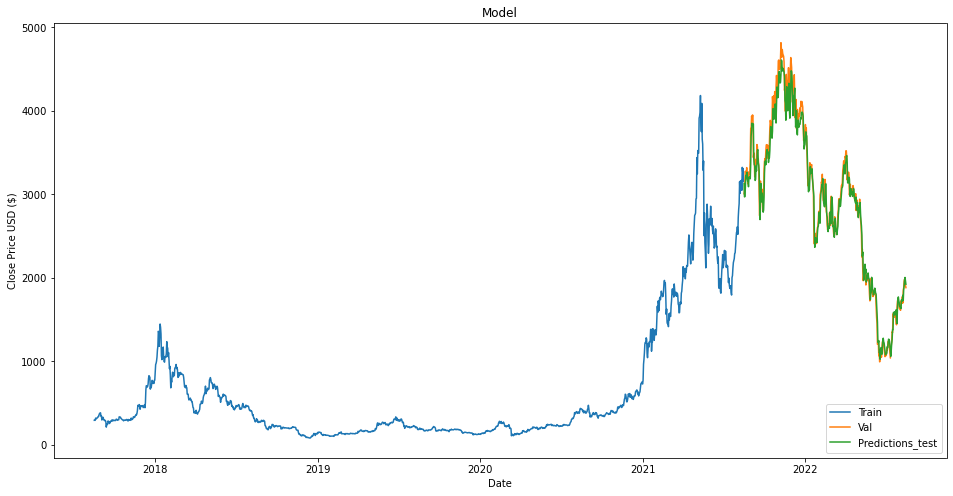

,ethereum
date,
2017-08-17,296.114635
2017-08-18,296.622090
2017-08-19,295.171577
2017-08-20,322.201220
2017-08-21,312.174471
...,...
2021-08-12,3048.412682
2021-08-13,3323.197991
2021-08-14,3268.548177


In [10]:

data = mydf.filter(['ethereum'])
train = data[:training_data_len]

# train = data[:len(x_train)]
validation = data[training_data_len:]
validation['Predictions_test'] = predictions_test
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train_pred)
plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions_test']])
plt.legend(['Train', 'Val', 'Predictions_test'], loc='lower right')
plt.show()

display(train)

C:\Users\fooba\AppData\Local\Temp/ipykernel_31028/3386552806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions_test'] = predictions_test*1.07


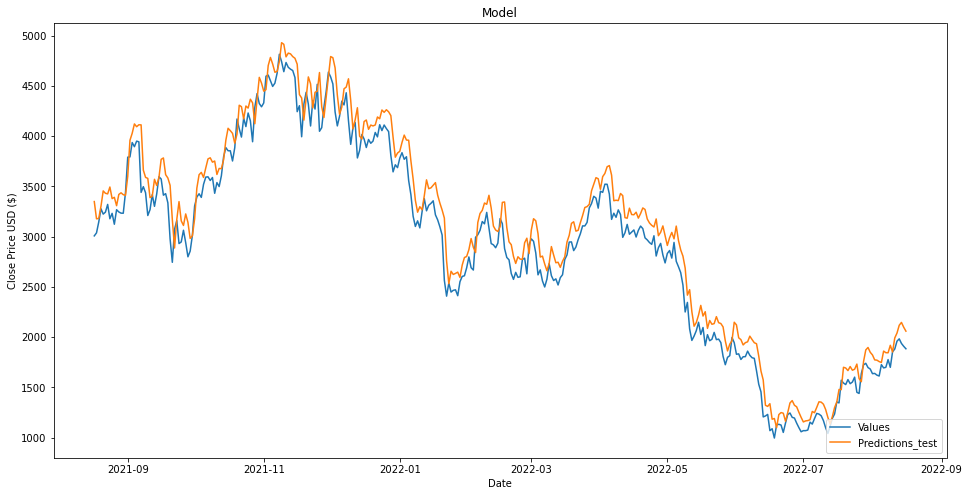

In [32]:
data = mydf.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions_test'] = predictions_test*1.07
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions_test']])
plt.legend(['Values', 'Predictions_test'], loc='lower right')
plt.show()

In [33]:
# buy when prediction is below price, and sell when prediction is above price
# validation['buy'] = if validation['ethereum'] > validation['Predictions']

moneyStart = 1000
money = moneyStart
eth = money/validation['ethereum'].iloc[1]



validation['buy'] = np.where(validation['ethereum'] > validation['Predictions_test'], 1, 0)
# validation['sell'] = np.where(validation['ethereum'] < validation['Predictions'], 1, 0)
validation['signal'] = validation['buy'].diff()
validation['money'] = moneyStart

validation = validation.iloc[1:, :]
validation['eth'] = moneyStart/eth
display(validation.head(5))


for index, row in validation.iterrows():
    if row['signal'] == 1:
#         print('buy')
#         print('money: ',  money, 'price: ', row['ethereum'])
        eth = money/row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money


        row['eth'] = eth
    elif row['signal'] == -1:
#         print('sell')
        money = eth*row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
    else:
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
        
display(validation)
#     print(moneyStart/row['Close'])


C:\Users\fooba\AppData\Local\Temp/ipykernel_31028/3665477680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['buy'] = np.where(validation['ethereum'] > validation['Predictions_test'], 1, 0)
C:\Users\fooba\AppData\Local\Temp/ipykernel_31028/3665477680.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['signal'] = validation['buy'].diff()
C:\Users\fooba\AppData\Local\Temp/ipykernel_31028/3665477680.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,ethereum,Predictions_test,buy,signal,money,eth
date,,,,,,
2021-08-18,3037.230251,3176.970459,0,0.0,1000,3037.230251
2021-08-19,3144.818437,3181.040771,0,0.0,1000,3037.230251
2021-08-20,3276.969837,3302.108398,0,0.0,1000,3037.230251
2021-08-21,3224.000460,3454.760742,0,0.0,1000,3037.230251
2021-08-22,3243.486358,3431.095459,0,0.0,1000,3037.230251


,ethereum,Predictions_test,buy,signal,money,eth
date,,,,,,
2021-08-18,3037.230251,3176.970459,0,0.0,1000.000000,0.329247
2021-08-19,3144.818437,3181.040771,0,0.0,1000.000000,0.329247
2021-08-20,3276.969837,3302.108398,0,0.0,1000.000000,0.329247
2021-08-21,3224.000460,3454.760742,0,0.0,1000.000000,0.329247
2021-08-22,3243.486358,3431.095459,0,0.0,1000.000000,0.329247
...,...,...,...,...,...,...
2022-08-12,1959.330925,2040.206543,0,0.0,1113.741349,0.591966
2022-08-13,1982.411828,2117.626221,0,0.0,1113.741349,0.591966
2022-08-14,1936.701164,2145.954590,0,0.0,1113.741349,0.591966


,ethereum,Predictions_test,buy,signal,money,eth
date,,,,,,
2021-08-18,3037.230251,3176.970459,0,0.0,1000.000000,0.329247
2021-08-19,3144.818437,3181.040771,0,0.0,1000.000000,0.329247
2021-08-20,3276.969837,3302.108398,0,0.0,1000.000000,0.329247
2021-08-21,3224.000460,3454.760742,0,0.0,1000.000000,0.329247
2021-08-22,3243.486358,3431.095459,0,0.0,1000.000000,0.329247
...,...,...,...,...,...,...
2022-08-12,1959.330925,2040.206543,0,0.0,1113.741349,0.591966
2022-08-13,1982.411828,2117.626221,0,0.0,1113.741349,0.591966
2022-08-14,1936.701164,2145.954590,0,0.0,1113.741349,0.591966


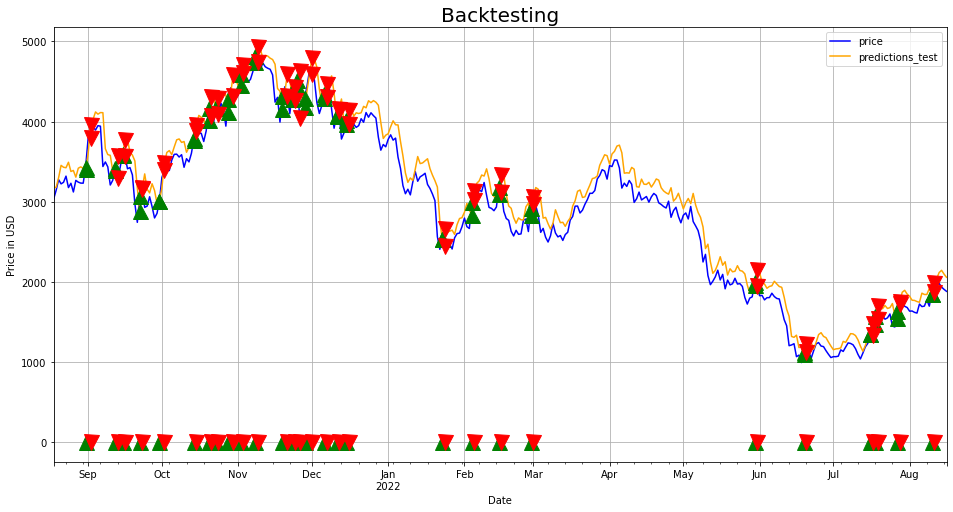

In [42]:
backtest = pd.DataFrame(validation)
display(backtest)
backtest = backtest.drop(columns=(['eth', 'money', 'buy']))
plt.figure(figsize = (16, 8))
backtest['ethereum'].plot(color='blue', label = 'price')
backtest['Predictions_test'].plot(color='orange', label='predictions_test')
plt.plot(backtest[backtest['signal']==1].index, backtest[backtest['signal']==1],'^', markersize = 15, color='g')
plt.plot(backtest[backtest['signal']==-1].index, backtest[backtest['signal']==-1],'v', markersize = 15, color='r')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('Backtesting', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

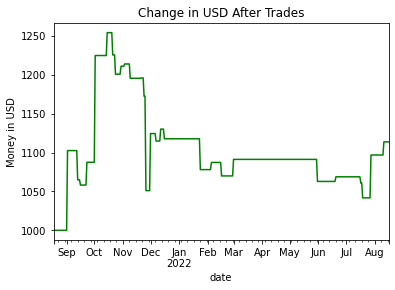

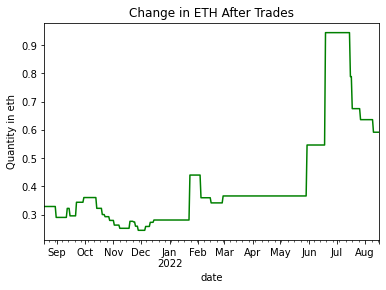

In [41]:
plt.xlabel('Date')
plt.ylabel('Money in USD')
plt.title('Change in USD After Trades')
validation['money'].plot(color='g', label = 'money')
plt.show()

plt.xlabel('Date')
plt.ylabel('Quantity in eth')
plt.title('Change in ETH After Trades')
validation['eth'].plot(color='g', label = 'eth')
plt.show()